In [1]:
import pandas as pd
import numpy as np
from joblib import load
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
%%time

names = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'S6', 'C6', 'S7', 'C7', 'CLASS']

dataset = pd.read_csv("training_data_6mln.csv").head(1000000)

def merge_to_dataset(dataset, data_frame, name_to_drop):
    return pd.merge(dataset, data_frame, how='left', left_index=True, right_index=True).drop([name_to_drop], axis=1)
def bincount2d_vectorized(a):
    n = a.max() + 1
    a_offs = a + np.arange(a.shape[0])[:, None] * n
    return np.bincount(a_offs.ravel(), minlength=a.shape[0] * n).reshape(-1, n)

CPU times: user 4.42 s, sys: 888 ms, total: 5.31 s
Wall time: 5.35 s


## Count total suits in each combination

In [3]:
%%time

S = dataset.iloc[:, [0, 2, 4, 6, 8, 10, 12]].astype(int)
S = pd.DataFrame(bincount2d_vectorized(S.values), columns=['suit0', 'suit1', 'suit2', 'suit3', 'suit4'])
dataset = merge_to_dataset(dataset, S, 'suit0')

R = dataset.iloc[:, np.arange(1, 14, 2)].astype(int)
cols = [f'rank{x}' for x in range(0, 14, 1)]
R = pd.DataFrame(bincount2d_vectorized(R.values), columns=cols)
dataset = merge_to_dataset(dataset, R, 'rank0')

R = dataset.loc[:, [f'rank{n}' for n in range(1, 14, 1)]].astype(int)
R = pd.DataFrame(bincount2d_vectorized(R.values), columns=[f'rankCount{n}' for n in range(0, 5, 1)])
dataset = merge_to_dataset(dataset, R, 'rankCount0')

dataset['diff1_13'] = dataset['rank1'] - dataset['rank13']
for i in range(2, 14, 1):
    dataset[f'diff{i}_{i - 1}'] = dataset[f'rank{i}'] - dataset[f'rank{i - 1}']

x_values = dataset.drop(['CLASS'], axis=1).values
y_values = dataset.CLASS.values

model = load('trained_model.joblib')

sc = StandardScaler()
x_values = sc.fit_transform(x_values)

y_pred = model.predict(x_values)

/Users/artemkozak/PycharmProjects/poker-ai/venv/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/artemkozak/PycharmProjects/poker-ai/venv/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


CPU times: user 18.1 s, sys: 11.6 s, total: 29.7 s
Wall time: 11.8 s


In [29]:
len(dataset.columns)

49

## Analyzing results

In [4]:
%%time

confusion_matrix(y_values, y_pred)

CPU times: user 167 ms, sys: 11.5 ms, total: 178 ms
Wall time: 177 ms


array([[174499,      0,      0,      0,      0,      0,      0,      0,
             0,      0],
       [     0, 438254,      0,      0,      0,      0,      0,      0,
             0,      0],
       [     0,      0, 235044,      0,      0,      0,      0,      0,
             0,      0],
       [     0,      0,      0,  48581,      0,      0,      0,      0,
             0,      0],
       [     0,      0,      0,      0,  45890,      0,      0,      0,
             0,      0],
       [     0,      0,      0,      0,      0,  28509,      0,      0,
             0,      0],
       [     0,      0,      0,      0,      0,      0,  25577,      0,
             0,      0],
       [     0,      0,      0,      0,      0,      0,      0,   1657,
             0,      0],
       [     0,      0,      0,      0,      0,      0,      0,      0,
          1729,      0],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0,    260]])

In [5]:
%%time

plt.hist((y_pred, y_values), bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], log=True)
plt.legend(labels=('preds', 'test'))

CPU times: user 95.5 ms, sys: 12.7 ms, total: 108 ms
Wall time: 110 ms


CPU times: user 27.6 ms, sys: 5.85 ms, total: 33.4 ms
Wall time: 29.5 ms


Text(0.5, 0, 'Час, секнуд')

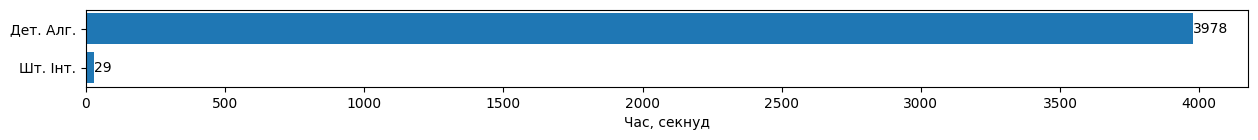

In [23]:
%%time

ar_time = 3978 # seconds
ml_time = 29 # seconds

indexes = ['Шт. Інт.', 'Дет. Алг.']
values = [ml_time, ar_time]

fig, ax = plt.subplots(figsize=(15, 1))
bars = ax.barh(indexes, values)
ax.bar_label(bars)
plt.xlabel('Час, секнуд')

In [24]:
ar_time / ml_time

137.17241379310346